In [2]:
!pip install -q transformers[torch]
!pip install -q -U datasets

In [60]:
from datasets import load_dataset

train_data, test_data = load_dataset("Shushant/NepaliSentiment", split=["train", "test"])

In [5]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchtext
from tqdm.auto import tqdm
import transformers

In [6]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Angeldahal404/ne-bert-tokenizer")

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/807k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [8]:
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["text"], add_special_tokens=True, truncation=True)["input_ids"]
    return {"ids": ids}


In [61]:
train_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 6000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1996
 }))

In [62]:
train_data = train_data.filter(lambda example: example["text"] is not None and len(example["text"]) > 0)
test_data = test_data.filter(lambda example: example["text"] is not None and len(example["text"]) > 0)

In [63]:
test_data, train_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 1995
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 5999
 }))

In [64]:
train_data = train_data.map(
    lambda example: tokenize_and_numericalize_example(example, tokenizer),
)
test_data = test_data.map(
    lambda example: tokenize_and_numericalize_example(example, tokenizer),
)


Map:   0%|          | 0/5999 [00:00<?, ? examples/s]

In [70]:
train_data = train_data.filter(lambda example: example["label"].isdigit())
train_data = train_data.map(lambda example: {"text": example["text"], "label": int(example["label"])})
test_data = test_data.filter(lambda example: example["label"].isdigit())
test_data = test_data.map(lambda example: {"text": example["text"], "label": int(example["label"])})

Filter:   0%|          | 0/5990 [00:00<?, ? examples/s]

AttributeError: 'int' object has no attribute 'isdigit'

In [66]:
# Define the labels to be removed
labels_to_remove = [11, 20]

# Filter out examples with labels to be removed from train_data
train_data = train_data.filter(lambda example: example["label"] not in labels_to_remove)

# Filter out examples with labels to be removed from test_data
test_data = test_data.filter(lambda example: example["label"] not in labels_to_remove)


Filter:   0%|          | 0/5992 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1993 [00:00<?, ? examples/s]

In [67]:
train_data, test_data

(Dataset({
     features: ['text', 'label', 'ids'],
     num_rows: 5990
 }),
 Dataset({
     features: ['text', 'label', 'ids'],
     num_rows: 1993
 }))

In [68]:
pad_index = tokenizer.pad_token_id

In [69]:
print(type(train_data["label"][0]))

<class 'int'>


In [71]:
test_size = 0.25

test_valid_data = test_data.train_test_split(test_size=test_size)
test_data = test_valid_data["train"]
valid_data = test_valid_data["test"]

In [72]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [91]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [92]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [93]:
batch_size = 8

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [94]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [95]:
model_ckpt = "google-bert/bert-base-multilingual-cased"

transformer = transformers.AutoModel.from_pretrained(model_ckpt)

In [96]:
print(type(train_data["label"]))

<class 'torch.Tensor'>


In [97]:
output_dim = len(train_data["label"].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [98]:
print(train_data["label"].unique())

tensor([0, 1, 2])


In [99]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 177,855,747 trainable parameters


In [100]:
lr = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [101]:
loss_fn = nn.CrossEntropyLoss()

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [103]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [104]:
def train(data_loader, model, loss_fn, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = loss_fn(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [105]:
def evaluate(data_loader, model, loss_fn, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = loss_fn(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [106]:
model = model.to(device)

In [113]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, loss_fn, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, loss_fn, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

training...:   0%|          | 0/749 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/63 [00:00<?, ?it/s]

epoch: 0
train_loss: 0.578, train_acc: 0.772
valid_loss: 0.918, valid_acc: 0.608


training...:   0%|          | 0/749 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/63 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.481, train_acc: 0.814
valid_loss: 1.049, valid_acc: 0.586


training...:   0%|          | 0/749 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/63 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.402, train_acc: 0.845
valid_loss: 1.044, valid_acc: 0.592


training...:   0%|          | 0/749 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/63 [00:00<?, ?it/s]

epoch: 3
train_loss: 0.349, train_acc: 0.861
valid_loss: 1.226, valid_acc: 0.554


training...:   0%|          | 0/749 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/63 [00:00<?, ?it/s]

epoch: 4
train_loss: 0.319, train_acc: 0.873
valid_loss: 1.079, valid_acc: 0.556


training...:   0%|          | 0/749 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/63 [00:00<?, ?it/s]

epoch: 5
train_loss: 0.288, train_acc: 0.880
valid_loss: 1.250, valid_acc: 0.589


training...:   0%|          | 0/749 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/63 [00:00<?, ?it/s]

epoch: 6
train_loss: 0.266, train_acc: 0.883
valid_loss: 1.291, valid_acc: 0.588


training...:   0%|          | 0/749 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/63 [00:00<?, ?it/s]

epoch: 7
train_loss: 0.252, train_acc: 0.888
valid_loss: 1.493, valid_acc: 0.540


training...:   0%|          | 0/749 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/63 [00:00<?, ?it/s]

epoch: 8
train_loss: 0.231, train_acc: 0.893
valid_loss: 1.456, valid_acc: 0.593


training...:   0%|          | 0/749 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/63 [00:00<?, ?it/s]

epoch: 9
train_loss: 0.215, train_acc: 0.896
valid_loss: 1.708, valid_acc: 0.562


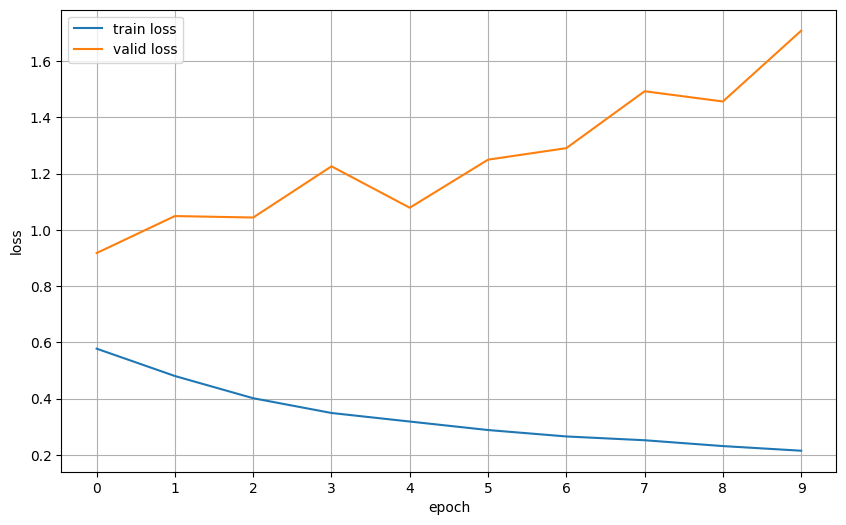

In [114]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

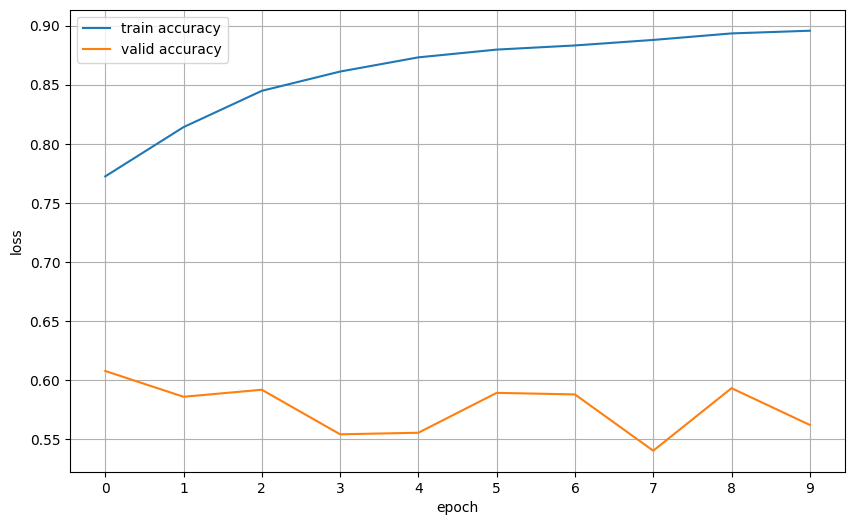

In [115]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [116]:
model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, loss_fn, device)

print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

evaluating...:   0%|          | 0/187 [00:00<?, ?it/s]

test_loss: 0.913, test_acc: 0.586


In [111]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"][:512]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [117]:
text = "मैले आफ्नो लक्ष्य प्राप्त गर्न सकेन।"
predict_sentiment(text, model, tokenizer, device)

(2, 0.47163650393486023)

In [118]:
text = "म खुशी छु।"
predict_sentiment(text, model, tokenizer, device)

(1, 0.9862143397331238)

In [119]:
text = "उसले मेरो सहायता गर्दैछ।"
predict_sentiment(text, model, tokenizer, device)

(1, 0.6755862236022949)